In [1]:
import numpy as np
from scipy.stats import norm
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
filename = r'../data/olhs_run1.xlsx'
x_pd = pd.read_excel(filename, sheet_name='Initial Design (OLHS)', header=[0,1], index_col=[0])
y_pd = pd.read_excel(filename, sheet_name='objectives', header=[0,1], index_col=[0])

In [3]:
#normalizing the inputs
xmeans = x_pd.mean(axis=0)
xstddv = x_pd.std(axis=0)
x_pd_normal = (x_pd - xmeans)/xstddv

x_pd = x_pd_normal

In [4]:
#normalize target labels
ymeans = y_pd.mean(axis=0)
ystddv = y_pd.std(axis=0)
y_pd_normal = (y_pd - ymeans)/ystddv

y_pd = y_pd_normal

In [5]:
validation_idx = [1, 7, 15]

train_x_pd = x_pd.drop(validation_idx)
train_y_pd = y_pd.drop(validation_idx)

test_x_pd = x_pd.loc[validation_idx, :]
test_y_pd = y_pd.loc[validation_idx, :]

In [6]:
#make torch tensors
train_x = torch.tensor(train_x_pd.values, dtype=torch.float)
train_y = torch.tensor(train_y_pd.values, dtype=torch.float).squeeze()

# test_x = torch.tensor(test_x_pd.values, dtype=torch.long)
# test_y = torch.tensor(test_y_pd.values, dtype=torch.long).squeeze()
test_x = torch.tensor(x_pd.values, dtype=torch.float)
test_y = torch.tensor(y_pd.values, dtype=torch.float).squeeze()

In [7]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=3
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=3, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [8]:
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=3)
model = MultitaskGPModel(train_x, train_y, likelihood)

In [9]:
training_iterations = 50
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.647
Iter 2/50 - Loss: 1.618
Iter 3/50 - Loss: 1.591
Iter 4/50 - Loss: 1.563
Iter 5/50 - Loss: 1.536
Iter 6/50 - Loss: 1.511
Iter 7/50 - Loss: 1.488
Iter 8/50 - Loss: 1.468
Iter 9/50 - Loss: 1.452
Iter 10/50 - Loss: 1.442
Iter 11/50 - Loss: 1.435
Iter 12/50 - Loss: 1.432
Iter 13/50 - Loss: 1.430
Iter 14/50 - Loss: 1.430
Iter 15/50 - Loss: 1.429
Iter 16/50 - Loss: 1.427
Iter 17/50 - Loss: 1.424
Iter 18/50 - Loss: 1.421
Iter 19/50 - Loss: 1.416
Iter 20/50 - Loss: 1.412
Iter 21/50 - Loss: 1.408
Iter 22/50 - Loss: 1.404
Iter 23/50 - Loss: 1.402
Iter 24/50 - Loss: 1.399
Iter 25/50 - Loss: 1.397
Iter 26/50 - Loss: 1.396
Iter 27/50 - Loss: 1.394
Iter 28/50 - Loss: 1.393
Iter 29/50 - Loss: 1.392
Iter 30/50 - Loss: 1.390
Iter 31/50 - Loss: 1.388
Iter 32/50 - Loss: 1.387
Iter 33/50 - Loss: 1.385
Iter 34/50 - Loss: 1.383
Iter 35/50 - Loss: 1.382
Iter 36/50 - Loss: 1.381
Iter 37/50 - Loss: 1.380
Iter 38/50 - Loss: 1.379
Iter 39/50 - Loss: 1.378
Iter 40/50 - Loss: 1.377
Iter 41/5

In [10]:
model.eval()
likelihood.eval()

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    pred = model(test_x)
    post_pred = likelihood(pred)
    pred_means = post_pred.mean
    pred_std = post_pred.stddev

/Users/gouravkumbhojkar/miniconda3/envs/myenv/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_2aa42nc2po/croot/pytorch-select_1700158700657/work/torch/csrc/utils/tensor_new.cpp:607.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


In [11]:
pred_means = pred_means * ystddv.values + ymeans.values
test_y = test_y * ystddv.values + ymeans.values

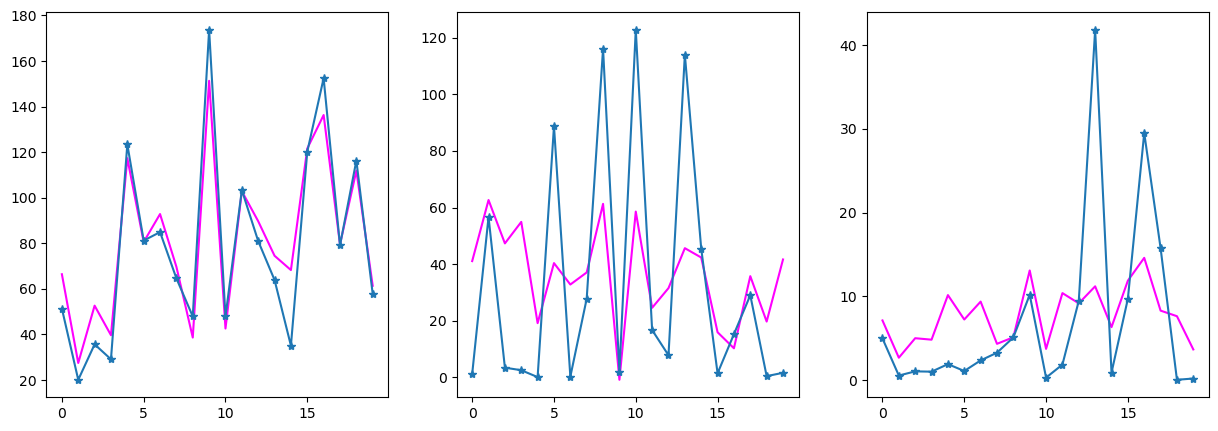

In [12]:
#Plots 
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].plot(pred_means[:, i], color='magenta')
    ax[i].plot(test_y[:, i], '-*')